In [1]:
# Install TensorFlow, Keras, and SqueezeNet
!pip install tensorflow keras

In [2]:
!pip install --upgrade tensorflow keras

In [3]:
!pip install keras-squeezenet

In [4]:
import os
import pandas as pd
import numpy as np 
import itertools
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras import applications  
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime  
import time 
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2
%matplotlib inline 

In [5]:
# Define image dimensions
img_width, img_height = 224, 224  # MobileNetV2 typically uses 224x224

# Define paths for saving model weights
top_model_weights_path = 'model/art_MobileNetV2_model.weights.h5'  

# Create necessary directories if they don't exist
os.makedirs(os.path.dirname(top_model_weights_path), exist_ok=True)

In [6]:
# Define dataset directories
train_data_dir = r'C:\Users\momo-\Downloads\archive\dataset\dataset_updated\training_set'  
validation_data_dir = r'C:\Users\momo-\Downloads\archive\dataset\dataset_updated\validation_set'  
test_data_dir = r'C:\Users\momo-\Downloads\archive\musemart\dataset_updated\validation_set'


In [7]:
# Define number of epochs and batch size
epochs = 30 
batch_size = 64 

In [8]:
# --- Image Validation and Preprocessing Functions ---
def validate_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify image integrity
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file detected: {file_path}. Removing file.")
                    os.remove(file_path)
            else:
                # Remove non-image files
                file_path = os.path.join(root, file)
                print(f"Non-image file detected: {file_path}. Removing file.")
                os.remove(file_path)

In [9]:
def convert_images_to_rgb(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # Check image mode
                        if img.mode in ('P', 'RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                            rgb_img = img.convert('RGB')
                            rgb_img.save(file_path)
                            print(f"Converted {file_path} to RGB")
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Could not convert {file_path}: {e}")
                    os.remove(file_path)
            else:
                # Remove non-image files
                file_path = os.path.join(root, file)
                print(f"Non-image file detected: {file_path}. Removing file.")
                os.remove(file_path)

In [10]:
def detailed_validate_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    invalid_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                        img = img.convert('RGB')  # Convert to RGB to ensure compatibility
                        img.save(file_path)
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file detected and removed: {file_path}. Error: {e}")
                    invalid_files.append(file_path)
                    os.remove(file_path)
            else:
                # Remove non-image files
                file_path = os.path.join(root, file)
                print(f"Non-image file detected and removed: {file_path}")
                os.remove(file_path)
    print(f"Total invalid or non-image files removed: {len(invalid_files)}")

In [11]:
def find_invalid_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    invalid_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file: {file_path}. Error: {e}")
                    invalid_files.append(file_path)
    print(f"Found {len(invalid_files)} invalid images.")
    return invalid_files


In [12]:
def safe_flow_from_directory(directory, **kwargs):
    datagen = ImageDataGenerator(**kwargs)
    generator = datagen.flow_from_directory(directory, **kwargs)
    while True:
        try:
            batch = next(generator)
            yield batch
        except UnidentifiedImageError as e:
            print(f"Skipped an invalid image: {e}")
            continue
        except StopIteration:
            break

In [13]:
# --- Load MobileNetV2 Model ---
# Load the MobileNetV2 model without the top classification layers
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of MobileNetV2 to prevent them from being trained
mobilenet.trainable = False

datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
# Start timing for training bottleneck features
start = datetime.datetime.now()

# Create generator for training data
generator_train = datagen.flow_from_directory(  
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    color_mode='rgb')  

nb_train_samples = len(generator_train.filenames)  
num_classes = len(generator_train.class_indices)  

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

# Generate bottleneck features for training data
bottleneck_features_train = mobilenet.predict(generator_train, steps=predict_size_train, verbose=1)  

# Save the bottleneck features
np.save('model/bottleneck_features_train.npy', bottleneck_features_train)

# End timing
end = datetime.datetime.now()
elapsed = end - start
print('Time for training bottleneck features:', elapsed) 

Found 7721 images belonging to 5 classes.


C:\Users\momo-\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step
Time for training bottleneck features: 0:04:17.185834


In [15]:
# Repeat the process for validation data
start = datetime.datetime.now()

generator_val = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False,
    color_mode='rgb'
)

nb_validation_samples = len(generator_val.filenames)
print(f"Number of validation samples: {nb_validation_samples}")

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = mobilenet.predict(
    generator_val,
    steps=predict_size_validation,
    verbose=1
)
np.save('model/bottleneck_features_validation.npy', bottleneck_features_validation)

end = datetime.datetime.now()
elapsed = end - start
print('Time for validation bottleneck features:', elapsed)

Found 856 images belonging to 5 classes.
Number of validation samples: 856
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
Time for validation bottleneck features: 0:00:39.703142


In [16]:
# Repeat the process for test data
start = datetime.datetime.now()

generator_test = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' to get labels
    shuffle=False,
    color_mode='rgb'
)

nb_test_samples = len(generator_test.filenames)
print(f"Number of test samples: {nb_test_samples}")

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

try:
    bottleneck_features_test = mobilenet.predict(generator_test, steps=predict_size_test, verbose=1)
    np.save('model/bottleneck_features_test.npy', bottleneck_features_test)
except UnidentifiedImageError as e:
    print(f"Error during test bottleneck features generation: {e}")
    # Optionally handle the error further

end = datetime.datetime.now()
elapsed = end - start
print('Time for test bottleneck features:', elapsed)

Found 265 images belonging to 5 classes.
Number of test samples: 265
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Time for test bottleneck features: 0:00:11.316963


In [17]:
# --- Load Bottleneck Features ---
train_data = np.load('model/bottleneck_features_train.npy')
train_labels = to_categorical(generator_train.classes, num_classes=num_classes)
validation_data = np.load('model/bottleneck_features_validation.npy')
validation_labels = to_categorical(generator_val.classes, num_classes=num_classes)


In [75]:
# Start timing for training the top model
start = datetime.datetime.now()

# Check data shapes
print("train_data shape:", train_data.shape)  
print("train_labels shape:", train_labels.shape)  
unique_labels = np.unique(train_labels)
print("Unique labels:", unique_labels)

# Adjust labels if necessary
if train_data.shape[0] != train_labels.shape[0]:
    print("Adjusting train_labels to match train_data...")
    train_labels = train_labels[:train_data.shape[0]]

# --- Build the Top Model ---
model = Sequential()
model.add(Input(shape=train_data.shape[1:]))  # Input layer
model.add(Flatten())
model.add(Dense(100))
model.add(tf.keras.layers.LeakyReLU(negative_slope=0.3))  # เปลี่ยน alpha เป็น negative_slope
model.add(Dropout(0.5))  
model.add(Dense(50))
model.add(tf.keras.layers.LeakyReLU(negative_slope=0.3))  # เปลี่ยน alpha เป็น negative_slope
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)  

# Train the model
history = model.fit(
    train_data, 
    train_labels,  
    epochs=7,
    batch_size=batch_size,  
    validation_data=(validation_data, validation_labels)
)  

# Save the model weights
model.save_weights(top_model_weights_path)  

# Evaluate the model on validation data
eval_loss, eval_accuracy = model.evaluate(
    validation_data, 
    validation_labels, 
    batch_size=batch_size, 
    verbose=1
)

print("[INFO] Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

# End timing
end = datetime.datetime.now()
elapsed = end - start
print('Time Elapsed:', elapsed)  

train_data shape: (7721, 7, 7, 1280)
train_labels shape: (7721, 5)
Unique labels: [0. 1.]
Epoch 1/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.7198 - loss: 1.2345 - val_accuracy: 0.9159 - val_loss: 0.2822
Epoch 2/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.8894 - loss: 0.4108 - val_accuracy: 0.9019 - val_loss: 0.3487
Epoch 3/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9140 - loss: 0.3384 - val_accuracy: 0.9089 - val_loss: 0.3900
Epoch 4/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9327 - loss: 0.2666 - val_accuracy: 0.9112 - val_loss: 0.4068
Epoch 5/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9495 - loss: 0.1910 - val_accuracy: 0.9136 - val_loss: 0.3799
Epoch 6/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9566 - loss: 0.1668 - val_accuracy: 0.9252 - val_loss: 0.4338
Epoch 7/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9627 - loss: 0.1414 - val_accuracy: 0.9182 - val_loss: 0.4777
14/14 

In [77]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     6,272,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,554,812 (47.89 MB)

 Trainable params: 6,277,405 (23.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,277,407 (23.95 MB)

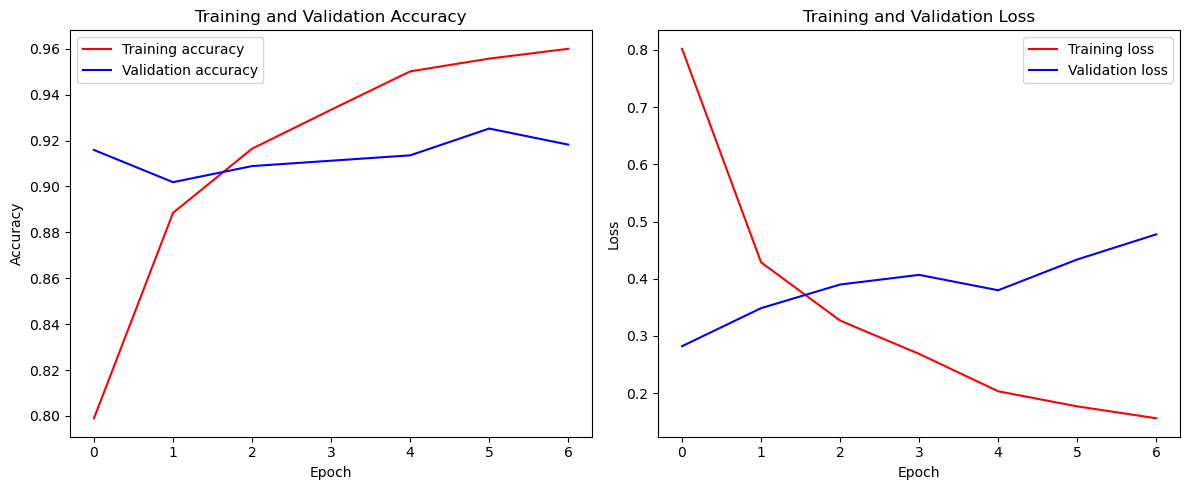

In [79]:
# --- Plot Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
# --- Evaluate on Test Data ---
test_data = np.load('model/bottleneck_features_test.npy')
test_labels = to_categorical(generator_test.classes, num_classes=num_classes)

test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
print("[INFO] Test Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("[INFO] Test Loss: {}".format(test_loss))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9826 - loss: 0.0509
[INFO] Test Accuracy: 98.87%
[INFO] Test Loss: 0.03931594267487526


In [83]:
# --- Generate Predictions and Confusion Matrix ---
# Generate predictions
preds = model.predict(test_data)
preds_rounded = np.round(preds, 0) 
print('Rounded Predictions:', preds_rounded)

# Convert one-hot encoded labels back to class labels
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Rounded Predictions: [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [85]:
# Generate classification report
art = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
classification_metrics = classification_report(
    categorical_test_labels, 
    categorical_preds, 
    target_names=art,
    zero_division=0
)
print(classification_metrics)


              precision    recall  f1-score   support

    drawings       0.89      1.00      0.94        17
   engraving       1.00      0.93      0.96        27
 iconography       1.00      0.99      0.99        75
    painting       0.99      1.00      0.99        95
   sculpture       1.00      1.00      1.00        51

    accuracy                           0.99       265
   macro avg       0.98      0.98      0.98       265
weighted avg       0.99      0.99      0.99       265



In [103]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [108]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


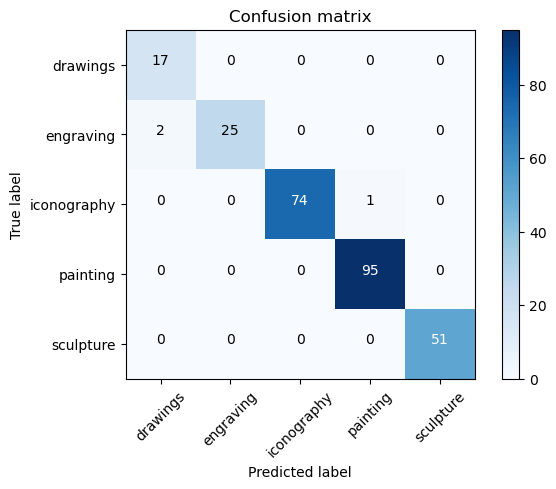

In [110]:
plot_confusion_matrix(confusion_matrix, ['drawings', 'engraving', 'iconography', 'painting', 'sculpture'])

<Figure size 1000x700 with 0 Axes>

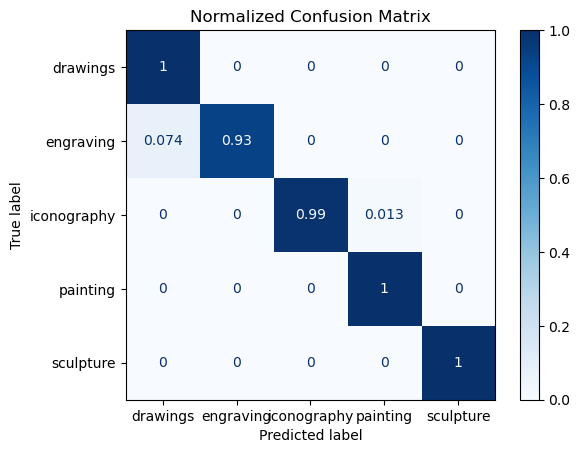

In [114]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot encoded labels back to class labels
test_labels_flat = np.argmax(test_labels, axis=1)
preds_flat = np.argmax(preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels_flat, preds_flat, labels=[0, 1, 2, 3, 4])

# Normalize the confusion matrix
def normalize_cm(cm):
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_cm[np.isnan(normalized_cm)] = 0
    return normalized_cm

normalized_cm = normalize_cm(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay(normalized_cm, display_labels=['drawings', 'engraving', 'iconography', 'painting', 'sculpture']).plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()


[INFO] Loading and preparing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
ID: 0, Label: drawings, Confidence: 0.06%
ID: 1, Label: engraving, Confidence: 0.0%
ID: 2, Label: iconography, Confidence: 0.0%
ID: 3, Label: painting, Confidence: 99.36%
ID: 4, Label: sculpture, Confidence: 0.58%
Final Decision:
.
..
...
ID: 3, Label: painting


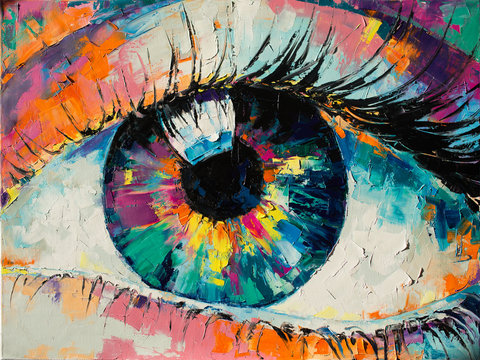

In [116]:
def read_image(file_path):
    print("[INFO] Loading and preparing image...")
    image = load_img(file_path, target_size=(img_width, img_height))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image
    
def test_single_image(path):
    art = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
    images = read_image(path)
    time.sleep(0.5)
    
    # Generate bottleneck features using MobileNetV2
    bt_prediction = mobilenet.predict(images)  
    preds = model.predict(bt_prediction)

    # Print prediction probabilities
    for idx, label, x in zip(range(len(art)), art, preds[0]):
        print(f"ID: {idx}, Label: {label}, Confidence: {round(x * 100, 2)}%")

    print('Final Decision:')
    time.sleep(0.5)
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(0.2)
    
    # Define class dictionary
    class_dictionary = {
        0: 'drawings',
        1: 'engraving',
        2: 'iconography',
        3: 'painting',
        4: 'sculpture'
    }

    # Get the predicted class
    class_predicted = np.argmax(preds, axis=1)  # Get the index of the max probability
    print("ID: {}, Label: {}".format(class_predicted[0], class_dictionary[class_predicted[0]]))  
    return load_img(path)

# Example usage (Update the path to your test image)
path = r'C:\Users\momo-\IMG_PJ\testPic.jpg'
test_single_image(path)